In [2]:
!pip3 install tsundoku

You are using pip version 18.0, however version 19.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [ ]:
!pip install sklearn torch tqdm nltk lazyme requests gensim
!python -m nltk.downloader movie_reviews

In [3]:
from IPython.display import display, Markdown, Latex
from tsundoku.word2vec_hints import *

# Overview


- <a href="#section-3-0">**3.0. Data Preparation**</a>
  - <a href="#section-3-0-1">3.0.1. *Vocabulary*</a>
    - <a href="#section-3-0-1-a"> Pet Peeve: using `gensim`</a>
  - <a href="#section-3-0-2">3.0.2. *Dataset*</a>  (<a href="#section-3-0-2-hints">Hints</a>)
    - <a href="#section-3-0-2-return-dict">Return `dict` in `__getitem__()`</a>
    - <a href="#section-3-0-2-labeleddata">Try `LabeledDataset`</a>
<br><br>
- <a href="#section-3-1">**3.1. Word2Vec from Scratch**</a>
  - <a href="#section-3-1-1">3.1.1. *CBOW*</a>
  - <a href="#section-3-1-2">3.1.2. *Skipgram*</a>
  - <a href="#section-3-1-3">3.1.3. *Word2Vec Dataset*</a> (<a href="#section-3-1-3-hint">Hints</a>)
  - <a href="#section-3-1-4-hint">3.1.4. *Train a CBOW model*</a>
    - <a href="#section-3-1-4-fill-cbow">Fill in the CBOW model</a>
    - <a href="#section-3-1-4-train-cbow">Train the model (*for real*)</a>
    - <a href="#section-3-1-4-evaluate-cbow">Evaluate the model</a>
    - <a href="#section-3-1-4-load-model">Load model at specific epoch</a>
  - <a href="#section-3-1-5">3.1.5. *Train a Skipgram model*</a>
    - <a href="#section-3-1-5-forward">Take a closer look at `forward()`</a>
    - <a href="#section-3-1-5-train">Train the model (*for real*)</a>
    - <a href="section-3-1-5-evaluate">Evaluate the model</a>
  - <a href="#section-3-1-6">3.1.6. *Loading Pre-trained Embeddings*</a>
    - <a href="#section-3-1-6-vocab">Override the Embedding vocabulary</a>
    - <a href="#section-3-1-6-pretrained">Override the Embedding weights</a>
    - <a href="#section-3-1-6-eval-skipgram">Evaluate on the Skipgram task</a>
    - <a href="#section-3-1-6-eval-cbow">Evaluate on the CBOW task</a>
    - <a href="#section-3-1-6-unfreeze-finetune">Unfreeeze and finetune</a>
    - <a href="#section-3-1-6-reval-cbow">Re-evaluate on the CBOW task</a>
<br><br>


<a id="section-3-0"></a>
# 3.0. Data Preparation

Before we train our own embeddings, lets first understand how to read text data into pytorch.
The native pytorch way to load datasets is to use the `torch.utils.data.Dataset` object.

There are already several other libraries that help with loading text datasets, e.g. 

 - FastAI https://docs.fast.ai/text.data.html
 - AllenNLP https://allenai.github.io/allennlp-docs/api/allennlp.data.dataset.html
 - Torch Text https://github.com/pytorch/text#data
 - Texar https://texar.readthedocs.io/en/latest/code/data.html#id4 
 - SpaCy https://github.com/explosion/thinc
 

But to truly understand and use it for the custom datasets you'll see at work, lets learn it the native way.

<a id="section-3-0-1"></a>
## 3.0.1  Vocabulary

Given a text, the first thing to do is to build a vocabulary (i.e. a dictionary of unique words) and assign an index to each unique word.

In [4]:
import random
from itertools import chain

from tqdm import tqdm
from gensim.corpora import Dictionary

import torch
from torch import nn, optim, tensor, autograd
from torch.nn import functional as F
from torch.utils.data import Dataset
import numpy as np

from functools import partial
from torch.utils.data import Dataset, DataLoader
from torch import functional as F


In [5]:
try: # Use the default NLTK tokenizer.
    from nltk import word_tokenize, sent_tokenize 
    # Testing whether it works. 
    # Sometimes it doesn't work on some machines because of setup issues.
    word_tokenize(sent_tokenize("This is a foobar sentence. Yes it is.")[0])
except: # Use a naive sentence tokenizer and toktok.
    import re
    from nltk.tokenize import ToktokTokenizer
    # See https://stackoverflow.com/a/25736515/610569
    sent_tokenize = lambda x: re.split(r'(?<=[^A-Z].[.?]) +(?=[A-Z])', x)
    # Use the toktok tokenizer that requires no dependencies.
    toktok = ToktokTokenizer()
    word_tokenize = word_tokenize = toktok.tokenize


In [6]:

text = """Language users never choose words randomly, and language is essentially
non-random. Statistical hypothesis testing uses a null hypothesis, which
posits randomness. Hence, when we look at linguistic phenomena in corpora, 
the null hypothesis will never be true. Moreover, where there is enough
data, we shall (almost) always be able to establish that it is not true. In
corpus studies, we frequently do have enough data, so the fact that a relation 
between two phenomena is demonstrably non-random, does not support the inference 
that it is not arbitrary. We present experimental evidence
of how arbitrary associations between word frequencies and corpora are
systematically non-random. We review literature in which hypothesis testing 
has been used, and show how it has often led to unhelpful or misleading results.""".lower()

tokenized_text = [word_tokenize(sent) for sent in sent_tokenize(text)]

uniq_tokens = set(chain(*tokenized_text))

vocab = {}   # Assign indices to every word.
idx2tok = {} # Also keep an dict of index to words.
for i, token in enumerate(uniq_tokens):
    vocab[token] = i
    idx2tok[i] = token

In [7]:
vocab

{'(': 68,
 ')': 79,
 ',': 49,
 '.': 70,
 'a': 8,
 'able': 27,
 'almost': 34,
 'always': 47,
 'and': 14,
 'arbitrary': 2,
 'are': 9,
 'associations': 61,
 'at': 69,
 'be': 35,
 'been': 73,
 'between': 25,
 'choose': 71,
 'corpora': 16,
 'corpus': 56,
 'data': 86,
 'demonstrably': 59,
 'do': 13,
 'does': 72,
 'enough': 26,
 'essentially': 10,
 'establish': 85,
 'evidence': 6,
 'experimental': 78,
 'fact': 17,
 'frequencies': 3,
 'frequently': 32,
 'has': 12,
 'have': 45,
 'hence': 15,
 'how': 29,
 'hypothesis': 66,
 'in': 76,
 'inference': 64,
 'is': 20,
 'it': 37,
 'language': 18,
 'led': 28,
 'linguistic': 23,
 'literature': 31,
 'look': 19,
 'misleading': 0,
 'moreover': 63,
 'never': 1,
 'non-random': 43,
 'not': 22,
 'null': 50,
 'of': 39,
 'often': 38,
 'or': 62,
 'phenomena': 55,
 'posits': 60,
 'present': 7,
 'randomly': 30,
 'randomness': 51,
 'relation': 24,
 'results': 52,
 'review': 48,
 'shall': 83,
 'show': 42,
 'so': 36,
 'statistical': 21,
 'studies': 54,
 'support': 33,


In [8]:
# Retrieve the index of the word 'corpora'
vocab['non-random']

43

In [9]:
# The indexed representation of the first sentence.

sent0 = tokenized_text[0]

[vocab[token] for token in sent0] 

[18, 40, 1, 71, 4, 30, 49, 14, 18, 20, 10, 43, 70]

<a id="section-3-0-1-a"></a>

### Pet Peeve (Gensim)

I (Liling) don't really like to write my own vectorizer the `gensim` has functions that are optimized for such operations. In fact, I've written a [whole preprocessing pipeline library for me to use for language modelling and machine translation purposes](https://github.com/alvations/komorebi/blob/master/komorebi/text.py) =)

Using `gensim`, I would have written the above as such:

In [10]:
from gensim.corpora.dictionary import Dictionary
vocab = Dictionary(tokenized_text)

In [11]:
# Note the key-value order is different of gensim from the native Python's
dict(vocab.items())

{0: ',',
 1: '.',
 2: 'and',
 3: 'choose',
 4: 'essentially',
 5: 'is',
 6: 'language',
 7: 'never',
 8: 'non-random',
 9: 'randomly',
 10: 'users',
 11: 'words',
 12: 'a',
 13: 'hypothesis',
 14: 'null',
 15: 'posits',
 16: 'randomness',
 17: 'statistical',
 18: 'testing',
 19: 'uses',
 20: 'which',
 21: 'at',
 22: 'be',
 23: 'corpora',
 24: 'hence',
 25: 'in',
 26: 'linguistic',
 27: 'look',
 28: 'phenomena',
 29: 'the',
 30: 'true',
 31: 'we',
 32: 'when',
 33: 'will',
 34: '(',
 35: ')',
 36: 'able',
 37: 'almost',
 38: 'always',
 39: 'data',
 40: 'enough',
 41: 'establish',
 42: 'it',
 43: 'moreover',
 44: 'not',
 45: 'shall',
 46: 'that',
 47: 'there',
 48: 'to',
 49: 'where',
 50: 'arbitrary',
 51: 'between',
 52: 'corpus',
 53: 'demonstrably',
 54: 'do',
 55: 'does',
 56: 'fact',
 57: 'frequently',
 58: 'have',
 59: 'inference',
 60: 'relation',
 61: 'so',
 62: 'studies',
 63: 'support',
 64: 'two',
 65: 'are',
 66: 'associations',
 67: 'evidence',
 68: 'experimental',
 69: 'fr

In [12]:
vocab.token2id['corpora']

23

In [13]:
vocab.doc2idx(sent0)

[6, 10, 7, 3, 11, 9, 0, 2, 6, 5, 4, 8, 1]

The "indexed form" of the tokens in the sentence forms the ***vectorized*** input to the `nn.Embedding` layer in PyTorch.

<a id="section-3-0-2"></a>

# 3.0.2 Dataset

Lets try creating a `torch.utils.data.Dataset` object.

In [14]:
from torch.utils.data import Dataset, DataLoader

class Text(Dataset):
    def __init__(self, tokenized_texts):
        """
        :param tokenized_texts: Tokenized text.
        :type tokenized_texts: list(list(str))
        """
        self.sents = tokenized_texts
        self.vocab = Dictionary(tokenized_texts)

    def __getitem__(self, index):
        """
        The primary entry point for PyTorch datasets.
        This is were you access the specific data row you want.
        
        :param index: Index to the data point.
        :type index: int
        """
        # Hint: You want to return a vectorized sentence here.
        return {'x': self.vectorize(self.sents[index])}

    def vectorize(self, tokens):
        """
        :param tokens: Tokens that should be vectorized. 
        :type tokens: list(str)
        """
        # See https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.doc2idx 
        return self.vocab.doc2idx(tokens)
    
    def unvectorize(self, indices):
        """
        :param indices: Converts the indices back to tokens.
        :type tokens: list(int)
        """
        return [self.vocab[i] for i in indices]

<a id="section-3-0-2-hints"></a>
## Hints to the above cell

In [15]:
# Option 1: To see the hint and partial code for the cell above, uncomment the following line.
##hint_dataset_vectorize()
##code_text_dataset_vectorize()

# Option 2: "I give up just, run the code for me" 
# Uncomment the next two lines, if you really gave up... 
#full_code_text_dataset_vectorize()
##from tsundoku.word2vec import Text


In [16]:
tokenized_text[5]

['we',
 'present',
 'experimental',
 'evidence',
 'of',
 'how',
 'arbitrary',
 'associations',
 'between',
 'word',
 'frequencies',
 'and',
 'corpora',
 'are',
 'systematically',
 'non-random',
 '.']

In [17]:
text_dataset = Text(tokenized_text)

In [18]:
text_dataset[5] # First sentence.

{'x': [31, 72, 68, 67, 71, 70, 50, 66, 51, 74, 69, 2, 23, 65, 73, 8, 1]}

<a id="section-3-0-2-return-dict"></a>

### Return `dict` in `__getitem__()`

This is nice if we're just representing sentences/documents by their indices but when we're doing machine learning, we usually have `X` and `Y`. 

If we have labels for the each sentence, we can also put it into to `__getitem__()` by having it return a dictionary.

In [19]:
from torch.utils.data import Dataset, DataLoader

class LabeledText(Dataset):
    def __init__(self, tokenized_texts, labels):
        """
        :param tokenized_texts: Tokenized text.
        :type tokenized_texts: list(list(str))
        """
        self.sents = tokenized_texts
        self.labels = labels # Sentence level labels.
        self.vocab = Dictionary(self.sents)

    def __getitem__(self, index):
        """
        The primary entry point for PyTorch datasets.
        This is were you access the specific data row you want.
        
        :param index: Index to the data point.
        :type index: int
        """
        return {'X': self.vectorize(self.sents[index]), 'Y': self.labels[index]}

    def vectorize(self, tokens):
        """
        :param tokens: Tokens that should be vectorized. 
        :type tokens: list(str)
        """
        # See https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.doc2idx 
        return self.vocab.doc2idx(tokens)
    
    def unvectorize(self, indices):
        """
        :param indices: Converts the indices back to tokens.
        :type tokens: list(int)
        """
        return [self.vocab[i] for i in indices]

<a id="section-3-0-2-labeleddata"></a>

### Lets try the `LabeledDataset` on a movie review corpus

In [20]:
from nltk.corpus import movie_reviews

In [21]:
documents = []
labels = []

for fileid in tqdm(movie_reviews.fileids()):
    label = fileid.split('/')[0]
    doc = word_tokenize(movie_reviews.open(fileid).read())
    documents.append(doc)
    labels.append(label)

100%|██████████| 2000/2000 [00:17<00:00, 111.99it/s]


In [22]:
documents[0]

['plot',
 ':',
 'two',
 'teen',
 'couples',
 'go',
 'to',
 'a',
 'church',
 'party',
 ',',
 'drink',
 'and',
 'then',
 'drive',
 '.',
 'they',
 'get',
 'into',
 'an',
 'accident',
 '.',
 'one',
 'of',
 'the',
 'guys',
 'dies',
 ',',
 'but',
 'his',
 'girlfriend',
 'continues',
 'to',
 'see',
 'him',
 'in',
 'her',
 'life',
 ',',
 'and',
 'has',
 'nightmares',
 '.',
 'what',
 "'s",
 'the',
 'deal',
 '?',
 'watch',
 'the',
 'movie',
 'and',
 '``',
 'sorta',
 '``',
 'find',
 'out',
 '.',
 '.',
 '.',
 'critique',
 ':',
 'a',
 'mind-fuck',
 'movie',
 'for',
 'the',
 'teen',
 'generation',
 'that',
 'touches',
 'on',
 'a',
 'very',
 'cool',
 'idea',
 ',',
 'but',
 'presents',
 'it',
 'in',
 'a',
 'very',
 'bad',
 'package',
 '.',
 'which',
 'is',
 'what',
 'makes',
 'this',
 'review',
 'an',
 'even',
 'harder',
 'one',
 'to',
 'write',
 ',',
 'since',
 'i',
 'generally',
 'applaud',
 'films',
 'which',
 'attempt',
 'to',
 'break',
 'the',
 'mold',
 ',',
 'mess',
 'with',
 'your',
 'head',
 '

In [23]:
labeled_dataset = LabeledText(documents, labels)

In [24]:
labeled_dataset[0]  # First review in the data.

{'X': [243,
  17,
  314,
  294,
  77,
  140,
  307,
  20,
  68,
  237,
  6,
  97,
  34,
  299,
  98,
  8,
  302,
  135,
  167,
  33,
  22,
  8,
  226,
  220,
  297,
  145,
  87,
  6,
  60,
  158,
  136,
  74,
  307,
  262,
  157,
  165,
  153,
  179,
  6,
  34,
  149,
  214,
  8,
  333,
  2,
  297,
  82,
  18,
  326,
  297,
  204,
  34,
  19,
  280,
  19,
  124,
  230,
  8,
  8,
  8,
  79,
  17,
  20,
  199,
  204,
  129,
  297,
  294,
  133,
  296,
  311,
  225,
  20,
  322,
  75,
  164,
  6,
  60,
  245,
  169,
  165,
  20,
  322,
  46,
  234,
  8,
  337,
  168,
  333,
  188,
  304,
  253,
  33,
  108,
  148,
  226,
  307,
  345,
  6,
  272,
  163,
  132,
  37,
  122,
  337,
  42,
  307,
  59,
  297,
  201,
  6,
  196,
  341,
  348,
  152,
  34,
  290,
  4,
  185,
  156,
  1,
  195,
  5,
  6,
  60,
  300,
  38,
  142,
  34,
  46,
  328,
  220,
  189,
  28,
  315,
  220,
  122,
  6,
  34,
  301,
  128,
  173,
  86,
  208,
  276,
  304,
  226,
  76,
  8,
  302,
  263,
  307,
  150,
  2

In [25]:
labeled_dataset[0]['X']  # Label of the first review in the data. 

[243,
 17,
 314,
 294,
 77,
 140,
 307,
 20,
 68,
 237,
 6,
 97,
 34,
 299,
 98,
 8,
 302,
 135,
 167,
 33,
 22,
 8,
 226,
 220,
 297,
 145,
 87,
 6,
 60,
 158,
 136,
 74,
 307,
 262,
 157,
 165,
 153,
 179,
 6,
 34,
 149,
 214,
 8,
 333,
 2,
 297,
 82,
 18,
 326,
 297,
 204,
 34,
 19,
 280,
 19,
 124,
 230,
 8,
 8,
 8,
 79,
 17,
 20,
 199,
 204,
 129,
 297,
 294,
 133,
 296,
 311,
 225,
 20,
 322,
 75,
 164,
 6,
 60,
 245,
 169,
 165,
 20,
 322,
 46,
 234,
 8,
 337,
 168,
 333,
 188,
 304,
 253,
 33,
 108,
 148,
 226,
 307,
 345,
 6,
 272,
 163,
 132,
 37,
 122,
 337,
 42,
 307,
 59,
 297,
 201,
 6,
 196,
 341,
 348,
 152,
 34,
 290,
 4,
 185,
 156,
 1,
 195,
 5,
 6,
 60,
 300,
 38,
 142,
 34,
 46,
 328,
 220,
 189,
 28,
 315,
 220,
 122,
 6,
 34,
 301,
 128,
 173,
 86,
 208,
 276,
 304,
 226,
 76,
 8,
 302,
 263,
 307,
 150,
 293,
 304,
 246,
 209,
 72,
 6,
 60,
 113,
 169,
 295,
 8,
 277,
 333,
 38,
 297,
 248,
 341,
 297,
 204,
 18,
 331,
 6,
 170,
 186,
 247,
 168,
 296,
 169,
 2,

<a id="section-3-1"></a>

# 3.1 Word2Vec Training

Word2Vec has two training variants:

 - **Continuous Bag of Words (CBOW)**: Predict center word from (bag of) context words.
 - **Skip-grams**: Predict context words given center word.
  
Visually, they look like this:

<img src="https://ibin.co/4UIznsOEyH7t.png" width="500" align="left">


<a id="section-3-1-1"></a>

## 3.1.1. CBOW

CBOW windows through the sentence and picks out the center word as the `Y` and the surrounding context words as the inputs `X`. 


In [26]:
from lazyme import per_window, per_chunk

xx =[1,2,3,4]
list(per_window(xx, n=2))
list(per_chunk(xx, n=3))

[(1, 2, 3), (4, None, None)]

In [27]:
def per_window(sequence, n=1):
    """
    From http://stackoverflow.com/q/42220614/610569
        >>> list(per_window([1,2,3,4], n=2))
        [(1, 2), (2, 3), (3, 4)]
        >>> list(per_window([1,2,3,4], n=3))
        [(1, 2, 3), (2, 3, 4)]
    """
    start, stop = 0, n
    seq = list(sequence)
    while stop <= len(seq):
        yield seq[start:stop]
        start += 1
        stop += 1

def cbow_iterator(tokens, window_size):
    n = window_size * 2 + 1
    for window in per_window(tokens, n):
        target = window.pop(window_size)
        yield window, target   # X = window ; Y = target. 


In [28]:
sent0 = ['language', 'users', 'never', 'choose', 'words', 'randomly', ',', 
         'and', 'language', 'is', 'essentially', 'non-random', '.']

In [29]:
list(cbow_iterator(sent0, 2)) 

[(['language', 'users', 'choose', 'words'], 'never'),
 (['users', 'never', 'words', 'randomly'], 'choose'),
 (['never', 'choose', 'randomly', ','], 'words'),
 (['choose', 'words', ',', 'and'], 'randomly'),
 (['words', 'randomly', 'and', 'language'], ','),
 (['randomly', ',', 'language', 'is'], 'and'),
 ([',', 'and', 'is', 'essentially'], 'language'),
 (['and', 'language', 'essentially', 'non-random'], 'is'),
 (['language', 'is', 'non-random', '.'], 'essentially')]

In [30]:
list(cbow_iterator(sent0, 3)) 

[(['language', 'users', 'never', 'words', 'randomly', ','], 'choose'),
 (['users', 'never', 'choose', 'randomly', ',', 'and'], 'words'),
 (['never', 'choose', 'words', ',', 'and', 'language'], 'randomly'),
 (['choose', 'words', 'randomly', 'and', 'language', 'is'], ','),
 (['words', 'randomly', ',', 'language', 'is', 'essentially'], 'and'),
 (['randomly', ',', 'and', 'is', 'essentially', 'non-random'], 'language'),
 ([',', 'and', 'language', 'essentially', 'non-random', '.'], 'is')]

<a id="section-3-1-2"></a>

## 3.1.2. Skipgram

Skipgram training windows through the sentence and pictures out the center word as the input `X` and the context words as the outputs `Y`, additionally, it will randommly sample words not in the window as **negative samples**.

In [31]:
def skipgram_iterator(tokens, window_size):
    n = window_size * 2 + 1 
    for i, window in enumerate(per_window(tokens, n)):
        target = window.pop(window_size)
        # Generate positive samples.
        for context_word in window:
            yield target, context_word, 1
        # Generate negative samples.
        for _ in range(n-1):
            leftovers = tokens[:i] + tokens[i+n:]
            yield target, random.choice(leftovers), 0

In [32]:
list(skipgram_iterator(sent0, 2))

[('never', 'language', 1),
 ('never', 'users', 1),
 ('never', 'choose', 1),
 ('never', 'words', 1),
 ('never', 'is', 0),
 ('never', 'randomly', 0),
 ('never', 'is', 0),
 ('never', 'randomly', 0),
 ('choose', 'users', 1),
 ('choose', 'never', 1),
 ('choose', 'words', 1),
 ('choose', 'randomly', 1),
 ('choose', 'language', 0),
 ('choose', '.', 0),
 ('choose', 'language', 0),
 ('choose', 'essentially', 0),
 ('words', 'never', 1),
 ('words', 'choose', 1),
 ('words', 'randomly', 1),
 ('words', ',', 1),
 ('words', 'users', 0),
 ('words', 'is', 0),
 ('words', 'non-random', 0),
 ('words', 'and', 0),
 ('randomly', 'choose', 1),
 ('randomly', 'words', 1),
 ('randomly', ',', 1),
 ('randomly', 'and', 1),
 ('randomly', 'is', 0),
 ('randomly', 'language', 0),
 ('randomly', 'language', 0),
 ('randomly', '.', 0),
 (',', 'words', 1),
 (',', 'randomly', 1),
 (',', 'and', 1),
 (',', 'language', 1),
 (',', 'never', 0),
 (',', 'never', 0),
 (',', 'users', 0),
 (',', '.', 0),
 ('and', 'randomly', 1),
 ('and

## Cut-away: What is `partial`?

The [`functools.partial`](https://docs.python.org/3.7/library/functools.html#functools.partial) function in Python is a mechanism to overload a function with preset arguments. 

For example:

In [33]:
from nltk import ngrams

# Generates bigrams
list(ngrams('this is a sentence'.split(), n=2))

[('this', 'is'), ('is', 'a'), ('a', 'sentence')]

In [34]:
from functools import partial

# You can create a new function that "preset" the `n` argument, e.g.
bigrams = partial(ngrams, n=2)
trigrams = partial(ngrams, n=3)

In [35]:
list(trigrams('this is a sentence'.split()))

[('this', 'is', 'a'), ('is', 'a', 'sentence')]

In [36]:
list(bigrams('this is a sentence'.split()))

[('this', 'is'), ('is', 'a'), ('a', 'sentence')]

<a id="section-3-1-3"></a>

## 3.1.3 Word2Vec Dataset

Now that we know what are the inputs `X` and outputs `Y` of the Word2Vec task. 

Lets put everything together and modify the `Dataset` so that `__getitem__` retrieves CBOW or Skipgram formats.

In [37]:
class Word2VecText(Dataset):
    def __init__(self, tokenized_texts, window_size, variant):
        """
        :param tokenized_texts: Tokenized text.
        :type tokenized_texts: list(list(str))
        """
        self.sents = tokenized_texts
        self._len = len(self.sents)
        self.vocab = Dictionary(self.sents)
        self.window_size = window_size
        self.variant = variant
        if variant.lower() == 'cbow':
            self._iterator = partial(self.cbow_iterator, window_size=self.window_size)
        elif variant.lower() == 'skipgram':
            self._iterator = partial(self.skipgram_iterator, window_size=self.window_size)

    def __getitem__(self, index):
        """
        The primary entry point for PyTorch datasets.
        This is were you access the specific data row you want.
        
        :param index: Index to the data point.
        :type index: int
        """
        vectorized_sent = self.vectorize(self.sents[index])
        
        return list(self._iterator(vectorized_sent))

    def __len__(self):
        return self._len
    
    def vectorize(self, tokens):
        """
        :param tokens: Tokens that should be vectorized. 
        :type tokens: list(str)
        """
        # See https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.doc2idx 
        return self.vocab.doc2idx(tokens)
    
    def unvectorize(self, indices):
        """
        :param indices: Converts the indices back to tokens.
        :type tokens: list(int)
        """
        return [self.vocab[i] for i in indices]

    def cbow_iterator(self,tokens, window_size):
        n = window_size * 2 + 1
        for window in per_window(tokens, n):
            target = window.pop(window_size)
            yield window, target   # X = window ; Y = target. 

    def skipgram_iterator(self, tokens, window_size):
        n = window_size * 2 + 1 
        for i, window in enumerate(per_window(tokens, n)):
            target = window.pop(window_size)
            # Generate positive samples.
            for context_word in window:
                yield target, context_word, 1
            # Generate negative samples.
            for _ in range(n-1):
                leftovers = tokens[:i] + tokens[i+n:]
                yield target, random.choice(leftovers), 0
                

<a id="section-3-1-3-hint"></a>
## Hints for the cell above.

In [38]:
# Option 1: To see the hint and partial code for the cell above, uncomment the following line.
##hint_word2vec_dataset()

# Option 2: "I give up just, run the code for me" 
# Uncomment the next two lines, if you really gave up... 
##full_code_word2vec_dataset()
##from tsundoku.word2vec import Word2VecText


<a id="section-3-1-4-hint"></a>

## 3.1.4. Train a CBOW model

### Lets Get Some Data

Lets take Kilgarriff (2005) , "Language is never ever, ever random". 

In [39]:
import os
import requests
import io #codecs


# Text version of https://kilgarriff.co.uk/Publications/2005-K-lineer.pdf
if os.path.isfile('language-never-random.txt'):
    with io.open('language-never-random.txt', encoding='utf8') as fin:
        text = fin.read()
else:
    url = "https://gist.githubusercontent.com/alvations/53b01e4076573fea47c6057120bb017a/raw/b01ff96a5f76848450e648f35da6497ca9454e4a/language-never-random.txt"
    text = requests.get(url).content.decode('utf8')
    with io.open('language-never-random.txt', 'w', encoding='utf8') as fout:
        fout.write(text)

tokenized_text = [list(map(str.lower, word_tokenize(sent))) for sent in sent_tokenize(text)]
window_size = 2
w2v_dataset = Word2VecText(tokenized_text, window_size=window_size, variant='cbow')

In [40]:
print(text[:1000])

                       Language is never, ever, ever, random

                                                               ADAM KILGARRIFF




Abstract
Language users never choose words randomly, and language is essentially
non-random. Statistical hypothesis testing uses a null hypothesis, which
posits randomness. Hence, when we look at linguistic phenomena in cor-
pora, the null hypothesis will never be true. Moreover, where there is enough
data, we shall (almost) always be able to establish that it is not true. In
corpus studies, we frequently do have enough data, so the fact that a rela-
tion between two phenomena is demonstrably non-random, does not sup-
port the inference that it is not arbitrary. We present experimental evidence
of how arbitrary associations between word frequencies and corpora are
systematically non-random. We review literature in which hypothesis test-
ing has been used, and show how it has often led to unhelpful or mislead-
ing results.
Keywords: 쎲쎲쎲

1. Int

In [41]:
# Sanity check, lets take a look at the data.
print(tokenized_text[0])

['language', 'is', 'never', ',', 'ever', ',', 'ever', ',', 'random', 'adam', 'kilgarriff', 'abstract', 'language', 'users', 'never', 'choose', 'words', 'randomly', ',', 'and', 'language', 'is', 'essentially', 'non-random', '.']


In [43]:
from lazyme import color_str

def visualize_predictions(x, y, prediction, vocab, window_size, unk='<unk>'):
    left = ' '.join([vocab.get(int(_x), '<unk>') for _x in x[:window_size]])
    right = ' '.join([vocab.get(int(_x), '<unk>') for _x in x[window_size:]])
    target = vocab.get(int(y), '<unk>')

    if not prediction:
        predicted_word = '______'
    else:
        predicted_word = vocab.get(int(prediction), '<unk>') 
    print(color_str(target, 'green'), '\t' if len(target) > 6 else '\t\t', 
          left, color_str(predicted_word, 'green' if target == predicted_word else 'red'), right)
    
device='cpu'
sent_idx = 10
window_size = 2
w2v_dataset = Word2VecText(tokenized_text, window_size=window_size, variant='cbow')
print(' '.join(w2v_dataset.sents[sent_idx]))
for w2v_io in w2v_dataset[sent_idx]:
    context, target = w2v_io
    context, target = tensor(context).to(device), tensor(target).to(device)
    visualize_predictions(context, target, None, w2v_dataset.vocab, window_size)

the bulk of linguistic questions concern the dis- tinction between a and m. a linguistic account of a phenomenon gen- erally gives us reason to view the relation between , for example , a verb ’ s syntax and its semantics , as motivated rather than arbitrary .
of 		 the bulk ______ linguistic questions
linguistic 	 bulk of ______ questions concern
questions 	 of linguistic ______ concern the
concern 	 linguistic questions ______ the dis-
the 		 questions concern ______ dis- tinction
dis- 		 concern the ______ tinction between
tinction 	 the dis- ______ between a
between 	 dis- tinction ______ a and
a 		 tinction between ______ and m.
and 		 between a ______ m. a
m. 		 a and ______ a linguistic
a 		 and m. ______ linguistic account
linguistic 	 m. a ______ account of
account 	 a linguistic ______ of a
of 		 linguistic account ______ a phenomenon
a 		 account of ______ phenomenon gen-
phenomenon 	 of a ______ gen- erally
gen- 		 a phenomenon ______ erally gives
erally 		 phenomenon gen- 

<a id="section-3-1-4-cbow-model"></a>

## Fill-in the code for the CBOW Model

<img src="https://lilianweng.github.io/lil-log/assets/images/word2vec-cbow.png" width="500" align="left">


(Image from https://lilianweng.github.io/lil-log/2017/10/15/learning-word-embedding.html)

In [44]:
import torch
from torch import nn, optim, tensor, autograd
from torch.nn import functional as F

class CBOW(nn.Module):
    def __init__(self, vocab_size, embd_size, context_size, hidden_size):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embd_size)
        self.linear1 = nn.Linear(2*context_size*embd_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, inputs):
        embedded = self.embeddings(inputs).view((1, -1))
        hid = F.relu(self.linear1(embedded))
        out = self.linear2(hid)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs


## Lets take a closer look from the inputs to the first `nn.Linear`

Cos after it reach the first `nn.Linear` it's just the same as our multi-layered perceptron example =)

In [46]:
# Lets take a look at the first output.
x, y = w2v_dataset[0][0][0],  w2v_dataset[0][0][1], 

x = tensor(x)
y = autograd.Variable(tensor(y, dtype=torch.long))
print(x)
print(y)

tensor([10,  8,  0,  7])
tensor(11)


In [47]:
embd_size = 5
emb = nn.Embedding(len(w2v_dataset.vocab), embd_size)
emb.state_dict()

OrderedDict([('weight', tensor([[ 0.7335,  1.5068, -0.5755, -1.6879,  0.9452],
                      [ 0.9425,  0.4316,  1.0516,  1.1749,  0.3975],
                      [-2.5105, -0.4638, -0.4089,  1.2706,  0.0488],
                      ...,
                      [-0.0080,  1.0538,  0.2862, -0.4308,  0.5077],
                      [ 0.8857, -1.0650, -0.0785, -1.4148, -0.7635],
                      [-0.5328,  0.1525, -2.1107, -0.2849,  0.3623]]))])

In [48]:
print(emb.state_dict()['weight'].shape)
emb.state_dict()['weight']

torch.Size([1388, 5])


tensor([[ 0.7335,  1.5068, -0.5755, -1.6879,  0.9452],
        [ 0.9425,  0.4316,  1.0516,  1.1749,  0.3975],
        [-2.5105, -0.4638, -0.4089,  1.2706,  0.0488],
        ...,
        [-0.0080,  1.0538,  0.2862, -0.4308,  0.5077],
        [ 0.8857, -1.0650, -0.0785, -1.4148, -0.7635],
        [-0.5328,  0.1525, -2.1107, -0.2849,  0.3623]])

In [49]:
print(emb(x).shape)
print(emb(x))

torch.Size([4, 5])
tensor([[-1.9476, -0.2496, -0.8896, -0.7262,  1.0757],
        [ 0.0027,  0.4123, -0.5250,  1.1259, -0.3427],
        [ 0.7335,  1.5068, -0.5755, -1.6879,  0.9452],
        [-2.0829, -0.0792,  0.3238,  0.4219,  1.2362]],
       grad_fn=<EmbeddingBackward>)


In [50]:
print(emb(x).view(1, -1).shape)
emb(x).view(1, -1)

torch.Size([1, 20])


tensor([[-1.9476, -0.2496, -0.8896, -0.7262,  1.0757,  0.0027,  0.4123, -0.5250,
          1.1259, -0.3427,  0.7335,  1.5068, -0.5755, -1.6879,  0.9452, -2.0829,
         -0.0792,  0.3238,  0.4219,  1.2362]], grad_fn=<ViewBackward>)

In [51]:
hidden_size = 100
lin1 = nn.Linear(len(x)*embd_size, hidden_size)
print(lin1.state_dict())

OrderedDict([('weight', tensor([[-0.1841,  0.0522,  0.2199,  ..., -0.1687, -0.1509,  0.0999],
        [-0.0486,  0.0334,  0.0295,  ...,  0.1646,  0.0800,  0.1874],
        [-0.1359, -0.1871,  0.1793,  ...,  0.1134, -0.1641,  0.0620],
        ...,
        [ 0.0740,  0.1689,  0.2059,  ..., -0.0074, -0.2086, -0.1302],
        [ 0.0827, -0.1457, -0.0466,  ..., -0.0417,  0.0796, -0.0143],
        [ 0.0882, -0.0164, -0.1430,  ...,  0.1532, -0.1963, -0.0777]])), ('bias', tensor([ 0.1782, -0.1608, -0.0011, -0.0666, -0.0324, -0.2057,  0.1821, -0.1774,
        -0.1428,  0.2019, -0.1390, -0.0183,  0.0534, -0.1038, -0.1622,  0.0726,
         0.0967, -0.2143, -0.1682, -0.0557, -0.2070,  0.1639,  0.1866,  0.1446,
        -0.2112,  0.0257,  0.2067,  0.1014,  0.2035,  0.2028, -0.1373, -0.1241,
        -0.2136,  0.2006,  0.1042, -0.0249,  0.1957,  0.1049,  0.0790, -0.1374,
        -0.0625,  0.2042,  0.2078, -0.1721,  0.1658,  0.0389,  0.1277, -0.0313,
        -0.2058, -0.1762,  0.1194, -0.1901,  0.0342

In [52]:
print(lin1.state_dict()['weight'].shape)
print(lin1.state_dict()['weight'])

torch.Size([100, 20])
tensor([[-0.1841,  0.0522,  0.2199,  ..., -0.1687, -0.1509,  0.0999],
        [-0.0486,  0.0334,  0.0295,  ...,  0.1646,  0.0800,  0.1874],
        [-0.1359, -0.1871,  0.1793,  ...,  0.1134, -0.1641,  0.0620],
        ...,
        [ 0.0740,  0.1689,  0.2059,  ..., -0.0074, -0.2086, -0.1302],
        [ 0.0827, -0.1457, -0.0466,  ..., -0.0417,  0.0796, -0.0143],
        [ 0.0882, -0.0164, -0.1430,  ...,  0.1532, -0.1963, -0.0777]])


In [53]:
print(lin1(emb(x).view(1, -1)).shape)
lin1(emb(x).view(1, -1))

torch.Size([1, 100])


tensor([[ 1.0888, -1.0088,  0.0965,  0.2756,  0.1797, -0.5882,  0.3243, -0.3393,
         -1.1270,  0.0161, -0.3290,  0.1747, -0.3472, -0.0795, -0.1349, -0.1686,
          0.5079, -0.3324, -0.2411, -0.7249, -0.8540, -0.7165,  0.1019,  0.4911,
         -0.5670,  0.4936, -0.6383,  0.3734,  0.1678, -0.1616, -0.5569, -0.9486,
         -0.0304,  0.6370,  0.1391,  0.4529,  0.1172,  0.3384, -0.4796,  0.2601,
         -0.6335, -1.6057, -0.4283,  0.2449,  0.6225, -0.8162, -0.2052, -0.1767,
          0.9683,  1.1005, -0.6824,  0.4383,  0.3045, -0.8560,  0.7744, -0.8682,
          0.9671, -0.1826,  0.0504, -0.0621,  0.3957,  0.4055,  0.1122,  0.0508,
         -0.5659, -0.2446, -0.2561,  0.1710,  0.8264,  0.9718, -0.1567, -0.8874,
          0.1698, -1.0425, -0.7192,  0.5400, -0.5012,  0.1647, -0.7856, -0.5713,
         -0.1210, -0.7652, -0.7464,  0.4228, -0.3050,  1.3325, -0.0095,  0.5470,
         -0.6679,  0.4492, -0.5300, -0.2526, -0.6127, -1.3180, -0.4840,  0.5257,
         -0.5755, -0.2315,  

In [54]:
relu = nn.ReLU()
print(relu(lin1(emb(x).view(1, -1))).shape)
relu(lin1(emb(x).view(1, -1)))

torch.Size([1, 100])


tensor([[1.0888, 0.0000, 0.0965, 0.2756, 0.1797, 0.0000, 0.3243, 0.0000, 0.0000,
         0.0161, 0.0000, 0.1747, 0.0000, 0.0000, 0.0000, 0.0000, 0.5079, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.1019, 0.4911, 0.0000, 0.4936, 0.0000,
         0.3734, 0.1678, 0.0000, 0.0000, 0.0000, 0.0000, 0.6370, 0.1391, 0.4529,
         0.1172, 0.3384, 0.0000, 0.2601, 0.0000, 0.0000, 0.0000, 0.2449, 0.6225,
         0.0000, 0.0000, 0.0000, 0.9683, 1.1005, 0.0000, 0.4383, 0.3045, 0.0000,
         0.7744, 0.0000, 0.9671, 0.0000, 0.0504, 0.0000, 0.3957, 0.4055, 0.1122,
         0.0508, 0.0000, 0.0000, 0.0000, 0.1710, 0.8264, 0.9718, 0.0000, 0.0000,
         0.1698, 0.0000, 0.0000, 0.5400, 0.0000, 0.1647, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.4228, 0.0000, 1.3325, 0.0000, 0.5470, 0.0000, 0.4492,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5257, 0.0000, 0.0000, 0.1337,
         0.0000]], grad_fn=<ThresholdBackward0>)

In [55]:
lin2 = nn.Linear(hidden_size, len(w2v_dataset.vocab))
print(lin2.state_dict()['weight'].shape)
lin2.state_dict()['weight']

torch.Size([1388, 100])


tensor([[ 0.0093, -0.0500, -0.0182,  ...,  0.0210, -0.0662, -0.0196],
        [ 0.0894,  0.0349, -0.0460,  ..., -0.0203,  0.0277, -0.0457],
        [ 0.0996,  0.0642,  0.0327,  ...,  0.0923,  0.0946,  0.0245],
        ...,
        [-0.0965, -0.0808, -0.0214,  ...,  0.0966, -0.0496, -0.0584],
        [ 0.0265,  0.0851, -0.0604,  ..., -0.0978,  0.0749,  0.0669],
        [-0.0632,  0.0624, -0.0602,  ...,  0.0833,  0.0041, -0.0210]])

In [56]:
h_x = relu(lin1(emb(x).view(1, -1)))
print(lin2(h_x).shape)
lin2(h_x)

torch.Size([1, 1388])


tensor([[ 0.2339,  0.3535, -0.2208,  ...,  0.0834,  0.0487,  0.1954]],
       grad_fn=<AddmmBackward>)

In [57]:
softmax = nn.LogSoftmax(dim=1)
softmax(lin2(h_x)).detach().numpy().tolist()

[[-7.026632308959961,
  -6.907124996185303,
  -7.4813947677612305,
  -7.3909196853637695,
  -7.239814281463623,
  -7.540319442749023,
  -7.456295967102051,
  -7.424745559692383,
  -7.198200702667236,
  -7.306450366973877,
  -7.160186767578125,
  -7.522230625152588,
  -7.079560279846191,
  -7.514706611633301,
  -7.365232467651367,
  -7.693469524383545,
  -7.305044174194336,
  -7.411624431610107,
  -7.21847677230835,
  -7.394266128540039,
  -7.056638240814209,
  -7.264041423797607,
  -7.241987228393555,
  -7.237301826477051,
  -7.260227203369141,
  -7.019230365753174,
  -7.0644917488098145,
  -7.718108177185059,
  -7.329542636871338,
  -7.173532485961914,
  -7.417546272277832,
  -7.222652912139893,
  -7.128057479858398,
  -7.118430137634277,
  -7.19818115234375,
  -7.476899147033691,
  -7.150943756103516,
  -7.399081707000732,
  -7.225815773010254,
  -7.49507474899292,
  -7.415511608123779,
  -7.4867448806762695,
  -7.331450462341309,
  -7.36598014831543,
  -7.291879177093506,
  -7.45012

In [58]:
# Select the index with highest softmax probabilities
torch.max(softmax(lin2(h_x)), 1)

(tensor([-6.6515], grad_fn=<MaxBackward0>), tensor([291]))

<a id="section-3-1-4-train-cbow"></a>

# Now, we train the CBOW model for real.

In [59]:
# First we split the data into training and testing.
from sklearn.model_selection import train_test_split

tokenized_text_train, tokenized_text_test = train_test_split(tokenized_text, test_size=0.1, random_state=42)
len(tokenized_text_train), len(tokenized_text_test)

(211, 24)

In [60]:
import torch
from torch import nn, optim, tensor, autograd
from torch.nn import functional as F

class CBOW(nn.Module):
    def __init__(self, vocab_size, embd_size, context_size, hidden_size):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embd_size)
        self.linear1 = nn.Linear(2*context_size*embd_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, inputs):
        embedded = self.embeddings(inputs).view((1, -1))
        hid = F.relu(self.linear1(embedded))
        out = self.linear2(hid)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs


In [61]:
embd_size = 100
learning_rate = 0.003
hidden_size = 100
window_size = 2

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Initialize the dataset.
w2v_dataset = Word2VecText(tokenized_text_train, window_size=window_size, variant='cbow')
vocab_size = len(w2v_dataset.vocab)

criterion = nn.NLLLoss()
model = CBOW(vocab_size, embd_size, window_size, hidden_size).to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

losses = []

model = nn.DataParallel(model)

num_epochs = 100
for _e in tqdm(range(num_epochs)):
    epoch_loss = []
    for sent_idx in range(w2v_dataset._len):
        for w2v_io in w2v_dataset[sent_idx]:
            # Retrieve the inputs and outputs.
            x, y = w2v_io
            x = tensor(x).to(device)
            y = autograd.Variable(tensor(y, dtype=torch.long)).to(device)
            # Zero gradient.
            model.zero_grad()
            # Calculate the log probability of the context embeddings.
            logprobs = model(x)
            # This unsqueeze thing is really a feature/bug... -_-
            loss = criterion(logprobs, y.unsqueeze(0)) 
            loss.backward()
            optimizer.step()
            epoch_loss.append(float(loss))
    # Save model after every epoch.
    torch.save(model.state_dict(), 'cbow_checkpoint_{}.pt'.format(_e))
    losses.append(sum(epoch_loss)/len(epoch_loss))



100%|██████████| 100/100 [10:42<00:00,  6.54s/it]


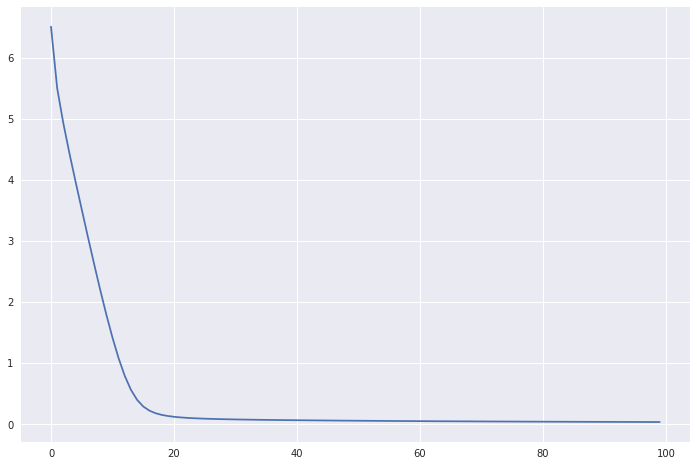

In [62]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(12, 8)})

plt.plot(losses)
plt.show()

<a id="section-3-1-4-evaluate-cbow"></a>

# Apply and Evaluate the CBOW Model 

In [68]:
type(w2v_io)

tuple

In [69]:
from lazyme import color_str

true_positive = 0
all_data = 0
# Iterate through the test sentences. 
for sent in tokenized_text_test:
    # Extract all the CBOW contexts (X) and targets (Y)
    for w2v_io in w2v_dataset._iterator(w2v_dataset.vectorize(sent)):
        # Retrieve the inputs and outputs.
        x = tensor(w2v_io[0])
        y = tensor(w2v_io[1])
        
        if -1 in x: # Skip unknown words.
            continue
            
        with torch.no_grad():
            _, prediction =  torch.max(model(x), 1)
        true_positive += int(prediction) == int(y)
        visualize_predictions(x, y, prediction, w2v_dataset.vocab, window_size=window_size)
        all_data += 1

is 		 the problem ______ essentially this
essentially 	 problem is not this :
this 		 is essentially random : if
: 		 essentially this used if a
if 		 this : of a word
a 		 : if a word (
word 		 if a web ( or
( 		 a word reason or bigram
or 		 word ( and bigram ,
bigram 		 ( or other , or
<unk> 		 , or plan , or
<unk> 		 , or not etc .
is 		 the web for a vast
a 		 web is not vast re-
vast 		 is a theoretical re- source
re- 		 a vast one source for
source 		 vast re- not for many
the 		 is that the association is
association 	 that the probability is random
is 		 the association between random ,
random 		 association is not , arbitrary
, 		 is random non- arbitrary ,
arbitrary 	 random , arbitrary , motivated
, 		 , arbitrary ______ motivated or
motivated 	 arbitrary , motivated or pre-
<unk> 		 or pre- p ( r
, 		 ( r and a ,
<unk> 		 a , here , p
their 		 however , and methods are
example 	 , for example , from
, 		 for example associated from just
from 		 example , so just those
<unk

<unk> 		 test con- does the fact
<unk> 		 cases are different in section
<unk> 		 of linguistic cells concern the
<unk> 		 the dis- differences between a
<unk> 		 a and roger a linguistic
<unk> 		 a linguistic subset of a
<unk> 		 reason to model the relation
between 	 the relation x , for
, 		 relation between language for example
for 		 between , or example ,
example 	 , for example , a
, 		 for example for a verb
a 		 example , we verb ’
verb 		 , a words ’ s
’ 		 a verb ’ s syntax
s 		 verb ’ s syntax and
syntax 		 ’ s definition and its
<unk> 		 and its false , as
motivated 	 , as words rather than
rather 		 as motivated and than arbitrary
than 		 motivated rather the arbitrary .
value 		 the average value of the
of 		 average value of the error
the 		 value of the error term
error 		 of the same term ,
term 		 the error model , language
, 		 error term this language is
language 	 term , it is never
is 		 , language is never ,
never 		 language is never , ever
, 		 is never ______

In [70]:
print('Accuracy:', true_positive/all_data)

Accuracy: 0.2553191489361702


<a id="section-3-1-4-load-model"></a>

# Go back to the 10th Epoch

In [71]:
model_10 = CBOW(vocab_size, embd_size, window_size, hidden_size)
model_10 = torch.nn.DataParallel(model_10)
model_10.load_state_dict(torch.load('cbow_checkpoint_10.pt'))
model_10.eval()

DataParallel(
  (module): CBOW(
    (embeddings): Embedding(1303, 100)
    (linear1): Linear(in_features=400, out_features=100, bias=True)
    (linear2): Linear(in_features=100, out_features=1303, bias=True)
  )
)

In [72]:

true_positive = 0
all_data = 0
# Iterate through the test sentences. 
for sent in tokenized_text_test:
    # Extract all the CBOW contexts (X) and targets (Y)
    for w2v_io in w2v_dataset._iterator(w2v_dataset.vectorize(sent)):
        # Retrieve the inputs and outputs.
        x = tensor(w2v_io[0])
        y = tensor(w2v_io[1])
        
        if -1 in x: # Skip unknown words.
            continue
            
        with torch.no_grad():
            _, prediction =  torch.max(model_10(x), 1)
        true_positive += int(prediction) == int(y)
        visualize_predictions(x, y, prediction, w2v_dataset.vocab, window_size=window_size)
        all_data += 1

is 		 the problem ______ essentially this
essentially 	 problem is not this :
this 		 is essentially random : if
: 		 essentially this for if a
if 		 this : of a word
a 		 : if a word (
word 		 if a 2 ( or
( 		 a word ( or bigram
or 		 word ( 1 bigram ,
bigram 		 ( or ) , or
<unk> 		 , or by , or
<unk> 		 , or were etc .
is 		 the web of a vast
a 		 web is not vast re-
vast 		 is a language re- source
re- 		 a vast random source for
source 		 vast re- corpus for many
the 		 is that the association is
association 	 that the probability is random
is 		 the association between random ,
random 		 association is not , arbitrary
, 		 is random language arbitrary ,
arbitrary 	 random , arbitrary , motivated
, 		 , arbitrary ______ motivated or
motivated 	 arbitrary , as or pre-
<unk> 		 or pre- p ( r
, 		 ( r and a ,
<unk> 		 a , which , p
their 		 however , and methods are
example 	 , for example , from
, 		 for example ______ from just
from 		 example , as just those
<unk> 		 just those a e

and 		 generated , and the hypothesis
the 		 , and the hypothesis test
hypothesis 	 and the hypothesis test con-
<unk> 		 test con- of the fact
<unk> 		 cases are all in section
<unk> 		 of linguistic corpora concern the
<unk> 		 the dis- is between a
<unk> 		 a and for a linguistic
<unk> 		 a linguistic subset of a
<unk> 		 reason to model the relation
between 	 the relation x , for
, 		 relation between language for example
for 		 between , was example ,
example 	 , for example , a
, 		 for example for a verb
a 		 example , we verb ’
verb 		 , a where ’ s
’ 		 a verb ’ s syntax
s 		 verb ’ s syntax and
syntax 		 ’ s definition and its
<unk> 		 and its arbitrary , as
motivated 	 , as words rather than
rather 		 as motivated and than arbitrary
than 		 motivated rather the arbitrary .
value 		 the average value of the
of 		 average value of the error
the 		 value of the error term
error 		 of the same term ,
term 		 the error term , language
, 		 error term this language is
language 	 t

In [73]:
print('Accuracy:', true_positive/all_data)

Accuracy: 0.2680851063829787


# [optional] How to Handle Unknown Words? 

This is not the best way to handle unknown words, but we can simply assign an index for unknown words.

**Hint:** Ensure that you have `gensim` version 3.7.0 first. Otherwise this part of the code won't work. Try `python -m pip install -U pip` and then `python -m pip install -U gensim==3.7.0`

In [75]:
vocab = Dictionary(['this is a foo bar sentence'.split()])
dict(vocab.items())

{0: 'a', 1: 'bar', 2: 'foo', 3: 'is', 4: 'sentence', 5: 'this'}

In [58]:
# See https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.patch_with_special_tokens
vocab = Dictionary(['this is a foo bar sentence'.split()])

try:
    special_tokens = {'<pad>': 0, '<unk>': 1}
    vocab.patch_with_special_tokens(special_tokens)
except: # If gensim is not 3.7.0
    pass
    
dict(vocab.items())

{6: 'a',
 7: 'bar',
 2: 'foo',
 3: 'is',
 4: 'sentence',
 5: 'this',
 0: '<pad>',
 1: '<unk>'}

# [optional] Lets Rewrite the `Word2VecText` Object

Now with the (i) unknown word patch in the vocabulary as well as (ii) `skipgram_iterator`

In [131]:
class Word2VecText(Dataset):
    def __init__(self, tokenized_texts, window_size, variant):
        """
        :param tokenized_texts: Tokenized text.
        :type tokenized_texts: list(list(str))
        """
        self.sents = tokenized_texts
        self._len = len(self.sents)
        
        # Add the unknown word patch here.
        self.vocab = Dictionary(self.sents)
        try:
            special_tokens = {'<pad>': 0, '<unk>': 1}
            self.vocab.patch_with_special_tokens(special_tokens)
        except:
            pass
        
        self.window_size = window_size
        self.variant = variant
        if variant.lower() == 'cbow':
            self._iterator = self.cbow_iterator
        elif variant.lower() == 'skipgram':
            self._iterator = self.skipgram_iterator

    def __getitem__(self, index):
        """
        The primary entry point for PyTorch datasets.
        This is were you access the specific data row you want.
        
        :param index: Index to the data point.
        :type index: int
        """
        vectorized_sent = self.vectorize(self.sents[index])
        
        return list(self._iterator(vectorized_sent, self.window_size))

    def __len__(self):
        return self._len
    
    def vectorize(self, tokens):
        """
        :param tokens: Tokens that should be vectorized. 
        :type tokens: list(str)
        """
        # See https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.doc2idx 
        return self.vocab.doc2idx(tokens, unknown_word_index=1)
    
    def unvectorize(self, indices):
        """
        :param indices: Converts the indices back to tokens.
        :type tokens: list(int)
        """
        return [self.vocab[i] for i in indices]
    
    def cbow_iterator(self, tokens, window_size):
        n = window_size * 2 + 1
        for window in per_window(tokens, n):
            target = window.pop(window_size)
            yield {'x': window, 'y': target}   # X = window ; Y = target. 
            
    def skipgram_iterator(self, tokens, window_size):
        n = window_size * 2 + 1 
        for i, window in enumerate(per_window(tokens, n)):
            focus = window.pop(window_size)
            # Generate positive samples.
            for context_word in window:
                yield {'x': (focus, context_word), 'y':1}
            # Generate negative samples.
            for _ in range(n-1):
                leftovers = tokens[:i] + tokens[i+n:]
                if leftovers:
                    yield {'x': (focus, random.choice(leftovers)), 'y':0}
                

<a id="section-3-1-5"></a>

# Lets try the skipgram task

In [132]:
class SkipGram(nn.Module):
    def __init__(self, vocab_size, embd_size):
        super(SkipGram, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embd_size)
    
    def forward(self, focus, context):
        embed_focus = self.embeddings(focus).view((1, -1))
        embed_context = self.embeddings(context).view((1, -1))
        # See https://pytorch.org/docs/stable/torch.html#torch.t
        score = torch.mm(embed_focus, torch.t(embed_context))
        log_probs = F.logsigmoid(score)
        return log_probs

<a id="section-3-1-5-foward"></a>

# Take a closer look at what's in the `forward()`

In [133]:
xx1 = torch.rand(1,20)
xx2 = torch.rand(1,20)

xx1_numpy = xx1.detach().numpy()
xx2_numpy = xx2.detach().numpy()

In [134]:
print(xx1_numpy.shape)
print(xx2_numpy.T.shape)
print(np.dot(xx1_numpy, xx2_numpy.T))

(1, 20)
(20, 1)
[[3.1778643]]


In [135]:
print(xx1.shape)
print(torch.t(xx2).shape) 

print(torch.mm(xx1, torch.t(xx2))) # 

torch.Size([1, 20])
torch.Size([20, 1])
tensor([[3.1779]])


<a id="section-3-1-5-train"></a>

# Train a Skipgram model (for real)

In [136]:

embd_size = 100
learning_rate = 0.03
hidden_size = 300
window_size = 3

# Initialize the dataset.
w2v_dataset = Word2VecText(tokenized_text_train, window_size=3, variant='skipgram')
vocab_size = len(w2v_dataset.vocab)

criterion = nn.MSELoss()
model = SkipGram(vocab_size, embd_size,).to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

losses = []

model = nn.DataParallel(model)

num_epochs = 100
for _e in tqdm(range(num_epochs)):
    epcoh_loss = 0
    for sent_idx in range(w2v_dataset._len):
        for w2v_io in w2v_dataset[sent_idx]:
            # Retrieve the inputs and outputs.
            x1, x2 = w2v_io['x']
            x1, x2 = tensor(x1).to(device), tensor(x2).to(device)
            y = autograd.Variable(tensor(w2v_io['y'], dtype=torch.float)).to(device)
            # Zero gradient.
            model.zero_grad()
            # Calculate the log probability of the context embeddings.
            logprobs = model(x1, x2)
            # This unsqueeze thing is really a feature/bug... -_-
            loss = criterion(logprobs, y.unsqueeze(0)) 
            loss.backward()
            optimizer.step()
            epcoh_loss += float(loss)
    torch.save(model.state_dict(), 'skipgram_checkpoint_{}.pt'.format(_e))
    losses.append(epcoh_loss)




  0%|          | 0/100 [00:00<?, ?it/s]


KeyboardInterrupt: 

<a id="section-3-1-5-evaluate"></a>

# Evaluate the model on the skipgram task

In [137]:

true_positive = 0
all_data = 0
# Iterate through the test sentences. 
for sent in tokenized_text_test:
    # Extract all the CBOW contexts (X) and targets (Y)
    for w2v_io in w2v_dataset._iterator(w2v_dataset.vectorize(sent)):
        model.zero_grad()
        # Retrieve the inputs and outputs.
        x1, x2 = w2v_io['x']
        x1, x2 = tensor(x1), tensor(x2)
        y = w2v_io['y']
        _, prediction =  torch.max(model(x1, x2), 1)    
        true_positive += int(prediction) == int(y)
        all_data += 1

TypeError: skipgram_iterator() missing 1 required positional argument: 'window_size'

In [138]:
print('Accuracy:', true_positive/all_data)

ZeroDivisionError: division by zero

## Download the Collobert and Weston SENNA Embeddings


If you're on a Mac or Linux, you can use the `!` bang commands in the next cell to get the data.

```
!pip install kaggle
!mkdir -p .kaggle
!echo '{"username":"natgillin","key":"54ae95ab760b52c3307ed4645c6c9b5d"}' > .kaggle/kaggle.json
!chmod 600 .kaggle/kaggle.json
!kaggle datasets download -d alvations/vegetables-senna-embeddings --force -p ./
```

If you're on windows go to https://www.kaggle.com/alvations/vegetables-senna-embeddings and download the data files. 

What's most important are the 
 - `.txt` file that contains the vocabulary list
 - `.npy` file that contains the binarized numpy array
 
The rows of the numpy array corresponds to the vocabulary in the order from the `.txt` file.

<a id="section-3-1-6-vocab"></a>


## 3.1.6. Loading Pre-trained Embeddings

Lets overwrite the `Word2VecText` object with the pretrained embeddings. 

Most important thing is the overwrite the `Dictionary` from `gensim` with the vocabulary of the pre-trained embeddings, as such:

```python
        # Loads the pretrained keys. 
        with open('senna.wiki-reuters.lm2.50d.txt') as fin:
            pretrained_keys = {line.strip():i for i, line in enumerate(fin)}
        self.vocab = Dictionary({})
        self.vocab.token2id = pretrained_keys
```


In [104]:
class Word2VecText(Dataset):
    def __init__(self, tokenized_texts, window_size, variant):
        """
        :param tokenized_texts: Tokenized text.
        :type tokenized_texts: list(list(str))
        """
        self.sents = tokenized_texts
        self._len = len(self.sents)
        
        # Loads the pretrained keys. 
        with open('senna.wiki-reuters.lm2.50d.txt') as fin:
            pretrained_keys = {line.strip():i for i, line in enumerate(fin)}
        self.vocab = Dictionary({})
        self.vocab.token2id = pretrained_keys
        
        self.window_size = window_size
        self.variant = variant
        if variant.lower() == 'cbow':
            self._iterator = partial(self.cbow_iterator, window_size=self.window_size)
        elif variant.lower() == 'skipgram':
            self._iterator = partial(self.skipgram_iterator, window_size=self.window_size)

    def __getitem__(self, index):
        """
        The primary entry point for PyTorch datasets.
        This is were you access the specific data row you want.
        
        :param index: Index to the data point.
        :type index: int
        """
        vectorized_sent = self.vectorize(self.sents[index])
        
        return list(self._iterator(vectorized_sent))

    def __len__(self):
        return self._len
    
    def vectorize(self, tokens):
        """
        :param tokens: Tokens that should be vectorized. 
        :type tokens: list(str)
        """
        # See https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.doc2idx 
        return self.vocab.doc2idx(tokens, unknown_word_index=-1)
    
    def unvectorize(self, indices):
        """
        :param indices: Converts the indices back to tokens.
        :type tokens: list(int)
        """
        return [self.vocab[i] for i in indices]
    
    def cbow_iterator(self, tokens, window_size):
        n = window_size * 2 + 1
        for window in per_window(tokens, n):
            target = window.pop(window_size)
            yield {'x': window, 'y': target}   # X = window ; Y = target. 
            
    def skipgram_iterator(self, tokens, window_size):
        n = window_size * 2 + 1 
        for i, window in enumerate(per_window(tokens, n)):
            focus = window.pop(window_size)
            # Generate positive samples.
            for context_word in window:
                yield {'x': (focus, context_word), 'y':1}
            # Generate negative samples.
            for _ in range(n-1):
                leftovers = tokens[:i] + tokens[i+n:]
                if leftovers:
                    yield {'x': (focus, random.choice(leftovers)), 'y':0}
                

<a id="section-3-1-6-pretrained"></a>

## Override the embeddings layer with the pre-trained weights.

In PyTorch, the weights of the `nn.Embedding` object can be easily overwritten with `from_pretrained` function, see https://pytorch.org/docs/stable/nn.html#embedding

In [105]:
class SkipGram(nn.Module):
    def __init__(self, pretrained_npy):
        super(SkipGram, self).__init__()
        self.embeddings = nn.Embedding.from_pretrained(pretrained_npy)
    
    def forward(self, focus, context):
        embed_focus = self.embeddings(focus).view((1, -1))
        embed_context = self.embeddings(context).view((1, -1))
        # See https://pytorch.org/docs/stable/torch.html#torch.t
        score = torch.mm(embed_focus, torch.t(embed_context))
        log_probs = F.logsigmoid(score)
        return log_probs

In [81]:
w2v_dataset = Word2VecText(tokenized_text_train, window_size=window_size, variant='skipgram')
pretrained_npy = torch.tensor(np.load('senna.wiki-reuters.lm2.50d.npy'))
pretrained_model = SkipGram(pretrained_npy)

NameError: name 'tokenized_text_train' is not defined

<a id="section-3-1-6-eval-skipgram"></a>
## Test Pretrained Embeddings on the Skipgram Task

In [106]:
true_positive = 0
all_data = 0
# Iterate through the test sentences. 
for sent in tokenized_text_test:
    # Extract all the CBOW contexts (X) and targets (Y)
    for w2v_io in w2v_dataset._iterator(w2v_dataset.vectorize(sent)):
        pretrained_model.zero_grad()
        # Retrieve the inputs and outputs.
        x1, x2 = w2v_io['x']
        if -1 in (x1, x2): # Skip unknown words.
            continue
        x1, x2 = tensor(x1), tensor(x2)
        y = w2v_io['y']
        with torch.no_grad():
            logprobs = pretrained_model(x1, x2)
            _, prediction =  torch.max(logprobs, 1)    
        true_positive += int(prediction) == int(y)
        all_data += 1

NameError: name 'tokenized_text_test' is not defined

In [107]:
with open('senna.wiki-reuters.lm2.50d.txt') as fin:
    pretrained_keys = {line.strip():i for i, line in enumerate(fin)}

In [108]:
print('Accuracy:', true_positive/all_data)

ZeroDivisionError: division by zero

<a id="section-3-1-6-eval-cbow"></a>
## Test Pretrained Embeddings on the CBOW Task

In [110]:
class CBOW(nn.Module):
    def __init__(self, pretrained_npy, context_size, hidden_size):
        super(CBOW, self).__init__()
        vocab_size, embd_size = list(pretrained_npy.shape)
        self.embeddings = nn.Embedding.from_pretrained(pretrained_npy)
        self.linear1 = nn.Linear(2*context_size*embd_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, inputs):
        embedded = self.embeddings(inputs).float().view((1, -1))
        hid = F.relu(self.linear1(embedded))
        out = self.linear2(hid)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs


In [111]:
window_size = 5
w2v_dataset = Word2VecText(tokenized_text_train, window_size=window_size, variant='cbow')
hidden_size = 300
pretrained_cbow_model = CBOW(pretrained_npy, window_size, hidden_size)

NameError: name 'tokenized_text_train' is not defined

In [112]:

true_positive = 0
all_data = 0
# Iterate through the test sentences. 
for sent in tokenized_text_test:
    # Extract all the CBOW contexts (X) and targets (Y)
    for w2v_io in w2v_dataset._iterator(w2v_dataset.vectorize(sent)):
        # Retrieve the inputs and outputs.
        x = tensor(w2v_io['x'])
        y = tensor(w2v_io['y'])
        
        if -1 in x: # Skip unknown words.
            continue
        with torch.no_grad():
            _, prediction =  torch.max(pretrained_cbow_model(x), 1)
        true_positive += int(prediction) == int(y)
        visualize_predictions(x, y, prediction, w2v_dataset.vocab, window_size=window_size)
        all_data += 1

NameError: name 'tokenized_text_test' is not defined

In [113]:
print('Accuracy:', true_positive/all_data)

ZeroDivisionError: division by zero

<a id="section-3-1-6-unfreeze-finetune"></a>
## Unfreeze the Embedddings and Tune it on the CBOW Task

In [114]:
class CBOW(nn.Module):
    def __init__(self, pretrained_npy, context_size, hidden_size):
        super(CBOW, self).__init__()
        vocab_size, embd_size = list(pretrained_npy.shape)
        self.embeddings = nn.Embedding.from_pretrained(pretrained_npy, freeze=False)
        self.linear1 = nn.Linear(2*context_size*embd_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, inputs):
        embedded = self.embeddings(inputs).float().view((1, -1))
        hid = F.relu(self.linear1(embedded))
        out = self.linear2(hid)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs


In [115]:
window_size = 2 
w2v_dataset = Word2VecText(tokenized_text_train, window_size=window_size, variant='cbow')
hidden_size = 300
pretrained_cbow_model = CBOW(pretrained_npy, window_size, hidden_size)

NameError: name 'tokenized_text_train' is not defined

In [116]:
learning_rate = 0.003
criterion = nn.NLLLoss()
optimizer = optim.SGD(pretrained_cbow_model.parameters(), lr=learning_rate)

losses = []

model = nn.DataParallel(pretrained_cbow_model)

num_epochs = 100
for _e in tqdm(range(num_epochs)):
    epoch_loss = []
    for sent_idx in range(w2v_dataset._len):
        for w2v_io in w2v_dataset[sent_idx]:
            # Retrieve the inputs and outputs.
            x = tensor(w2v_io['x'])
            y = autograd.Variable(tensor(w2v_io['y'], dtype=torch.long))
            
            if -1 in x or int(y) == -1:
                continue
            # Zero gradient.
            model.zero_grad()
            # Calculate the log probability of the context embeddings.
            logprobs = pretrained_cbow_model(x)
            # This unsqueeze thing is really a feature/bug... -_-
            loss = criterion(logprobs, y.unsqueeze(0)) 
            loss.backward()
            optimizer.step()
            epoch_loss.append(float(loss))
    # Save model after every epoch.
    torch.save(model.state_dict(), 'cbow_finetuning_checkpoint_{}.pt'.format(_e))
    losses.append(sum(epoch_loss)/len(epoch_loss))



NameError: name 'pretrained_cbow_model' is not defined

<a id="section-3-1-6-reval-cbow"></a>

## Re-Test Pretrained Embeddings on the CBOW Task

In [ ]:

true_positive = 0
all_data = 0
# Iterate through the test sentences. 
for sent in tokenized_text_test:
    # Extract all the CBOW contexts (X) and targets (Y)
    for w2v_io in w2v_dataset._iterator(w2v_dataset.vectorize(sent)):
        # Retrieve the inputs and outputs.
        x = tensor(w2v_io['x'])
        y = tensor(w2v_io['y'])
        
        if -1 in x: # Skip unknown words.
            continue
        with torch.no_grad():
            _, prediction =  torch.max(pretrained_cbow_model(x), 1)
        true_positive += int(prediction) == int(y)
        visualize_predictions(x, y, prediction, w2v_dataset.vocab, window_size=window_size)
        all_data += 1

In [117]:
print('Accuracy:', true_positive/all_data)

ZeroDivisionError: division by zero